In [ ]:
# This notebook use harmonic regression coefficients and RMSE to classify invasive and native species using iNaturalist data as training sites

In [6]:
# Import packages
import sprf
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest
import glob
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import geocube
from geocube.api.core import make_geocube
import rasterio as rio
from rasterio.plot import show
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
from geo_northarrow import add_north_arrow

In [7]:
# Working directory
!cd

C:\Users\Chad\Desktop\InvasiveProject\Invasive-Understory-Species


# Get and clean data from harmonic regression

In [59]:
# Get file paths for all the harmonic regression results
harmreg_fps=glob.glob('../Working_Data/*harmreg*')
harmreg_fps

['../Working_Data\\B11harmreg.csv',
 '../Working_Data\\B12harmreg.csv',
 '../Working_Data\\B2harmreg.csv',
 '../Working_Data\\B3harmreg.csv',
 '../Working_Data\\B4harmreg.csv',
 '../Working_Data\\B5harmreg.csv',
 '../Working_Data\\B6harmreg.csv',
 '../Working_Data\\B7harmreg.csv',
 '../Working_Data\\B8Aharmreg.csv',
 '../Working_Data\\B8harmreg.csv',
 '../Working_Data\\NBRharmreg.csv',
 '../Working_Data\\NDVIharmreg.csv',
 '../Working_Data\\RENDVIharmreg.csv',
 '../Working_Data\\SAVIharmreg.csv']

In [60]:
#Read in all cleaned data
AllData=gpd.read_file('../Working_Data/2023BandsIndicesCleaned.shp',engine="pyogrio").dropna()

In [61]:
# DataFrame with PtID and their corresponding geometries
PointsIDCrossWalk=AllData[['PtID','geometry']].drop_duplicates().reset_index()

In [62]:
#Note that in creating the data in the HPC, somehow some [] got added so these were removed in notepad
#Looping through each chunk of harmonic regression results and using PtID crosswalk to recombine everything 
bandsInd=['B3','B4','B5','B6','B7','B8','B8A','B11','B12','NBR','NDVI','RENDVI','SAVI']
current=pd.read_csv('../Working_Data/B2harmreg.csv').iloc[:53064,:]

#When exporting data from HPC, PtID was incorrectly assigned so is fixed here
current['PtID']=current.index
current['RMSE']=current['RMSE'].to_list()

#Joining data for first dataset and then looping through the rest
joined_gdf=PointsIDCrossWalk.join(current, on='PtID',rsuffix='B2')
for band in bandsInd:
    current=pd.read_csv('../Working_Data/'+band+'harmreg.csv').iloc[:53064,:]
    current['RMSE']=current['RMSE'].to_list()
    current['PtID']=current.index
    joined_gdf=joined_gdf.join(current, on='PtID',rsuffix=band)

In [63]:
# Drop unneeded columns
joined_gdf.drop(['index','Unnamed: 0','Unnamed: 0B3','Unnamed: 0B4','Unnamed: 0B5','Unnamed: 0B6','Unnamed: 0B7','Unnamed: 0B8','Unnamed: 0B8A','Unnamed: 0B11','Unnamed: 0B12','Unnamed: 0NDVI','Unnamed: 0RENDVI','Unnamed: 0SAVI','Unnamed: 0NBR','PtIDB2','PtIDB3','PtIDB4','PtIDB5','PtIDB6','PtIDB7','PtIDB8','PtIDB8A','PtIDB11','PtIDB12','PtIDNBR','PtIDNDVI','PtIDRENDVI','PtIDSAVI'], axis=1, inplace=True)

In [64]:
# Check columns
joined_gdf.columns

Index(['PtID', 'geometry', 'RMSE', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       ...
       'RMSESAVI', 'aSAVI', 'bSAVI', 'cSAVI', 'dSAVI', 'eSAVI', 'fSAVI',
       'gSAVI', 'hSAVI', 'iSAVI'],
      dtype='object', length=142)

# Split into test, train, and validation datasets

# Training sites from iNaturalist

In [65]:
#Boston boundary
towns=gpd.read_file('../Working_Data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp').to_crs(epsg=3857).dissolve('NAMELSAD20')
Boston_gdf=towns[towns.index=='Boston city']

In [66]:
#Deciduous Forests
forestpolygons=gpd.read_file('../Working_Data/dforestBoston.shp').to_crs(epsg=3857)

In [67]:
# Multiflora rose, bittersweet, glossy buckthorn
bittersweet=gpd.read_file('../Working_Data/Invasives/Bittersweet.shp',engine="pyogrio").clip(forestpolygons)
multiflora=gpd.read_file('../Working_Data/Invasives/Multiflora.shp',engine="pyogrio").clip(forestpolygons)
buckthorn=gpd.read_file('../Working_Data/Invasives/Buckthorn.shp',engine="pyogrio").clip(forestpolygons)
greenbrier=gpd.read_file('../Working_Data/Invasives/Greenbrier.shp',engine="pyogrio").clip(forestpolygons)
laurel=gpd.read_file('../Working_Data/Invasives/Laurel.shp',engine="pyogrio").clip(forestpolygons)

In [68]:
# Creating binary code for invasive vs native plants
bittersweet['invasive']=1
multiflora['invasive']=1
buckthorn['invasive']=1
greenbrier['invasive']=0
laurel['invasive']=0

In [69]:
laurel['invasive'].size

4

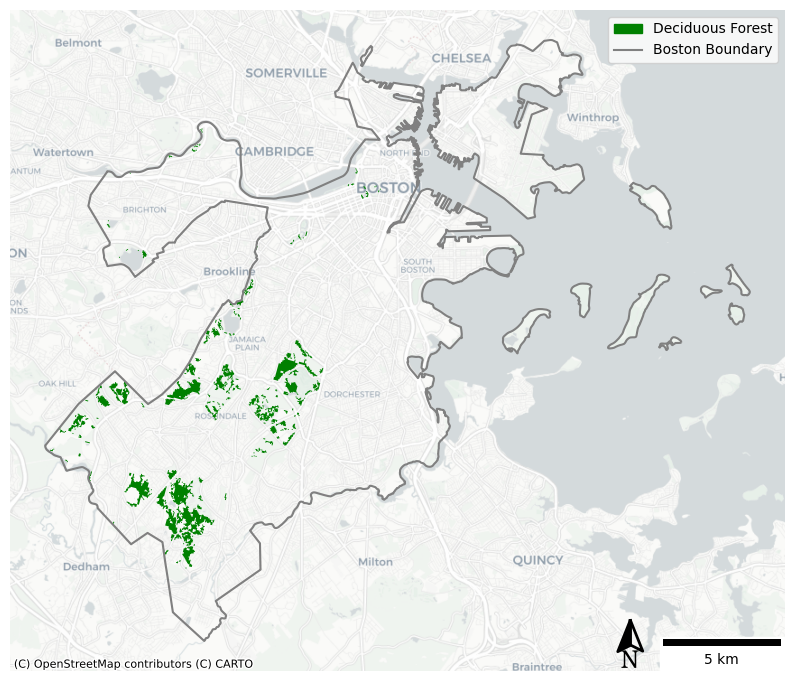

In [70]:
# Plot of deciduous forest in Boston
ax=Boston_gdf.boundary.plot(color='gray',figsize=(10,10))
forestpolygons.plot(color='green',ax=ax)
plt.title("")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
a=mpl.patches.Patch(color='green',label='Deciduous Forest')
b=mpl.lines.Line2D([0], [0], label='Boston Boundary', color='gray')
handles, labels = ax.get_legend_handles_labels()
handles.extend([a,b])
ax.legend(handles=handles)
ax.add_artist(ScaleBar(1,location='lower right'))
add_north_arrow(ax, scale=.4, xlim_pos=.8, ylim_pos=.03, color='#000', text_scaler=4, text_yT=-1.25)
plt.savefig('Deciduous forest boston.png',dpi=300,bbox_inches='tight')

C:\Users\Chad\AppData\Local\Temp\ipykernel_24036\3526152129.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


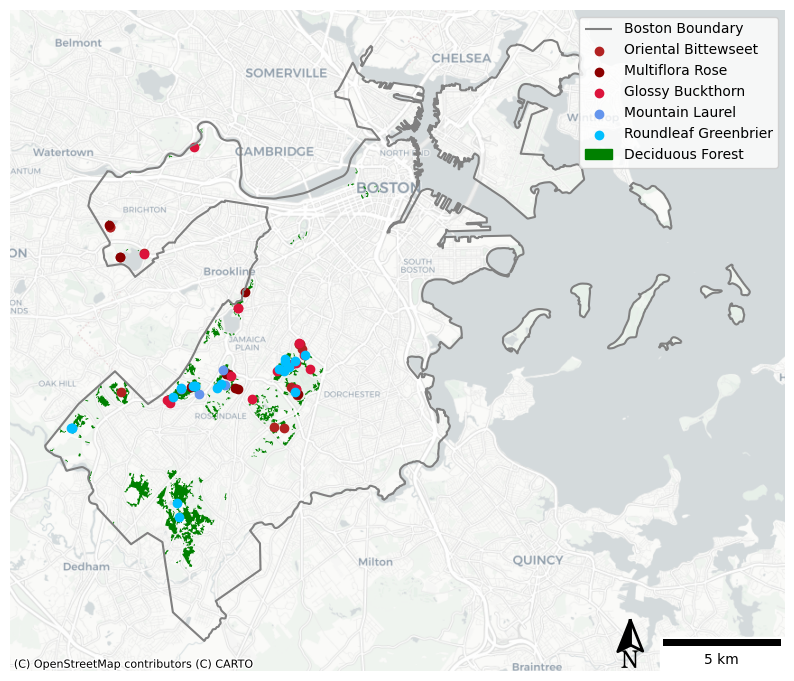

In [71]:
# Show training sites
fig,ax=plt.subplots(figsize=(10,10))
Boston_gdf.to_crs(epsg=3857).boundary.plot(color='gray',ax=ax,label='Boston Boundary')
forestpolygons.to_crs(epsg=3857).plot(color='green',ax=ax,label='Deciduous Forest')
bittersweet.to_crs(epsg=3857).plot(color='firebrick',ax=ax,label='Oriental Bittewseet')
multiflora.to_crs(epsg=3857).plot(color='darkred',ax=ax,label='Multiflora Rose')
buckthorn.to_crs(epsg=3857).plot(color='crimson',ax=ax,label='Glossy Buckthorn')
laurel.to_crs(epsg=3857).plot(color='cornflowerblue',ax=ax,label='Mountain Laurel')
greenbrier.to_crs(epsg=3857).plot(color='deepskyblue',ax=ax,label='Roundleaf Greenbrier')
plt.title("")

a=mpl.patches.Patch(color='green',label='Deciduous Forest')

cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

handles, labels = ax.get_legend_handles_labels()
handles.extend([a])
ax.legend(handles=handles)
add_north_arrow(ax, scale=.4, xlim_pos=.8, ylim_pos=.03, color='#000', text_scaler=4, text_yT=-1.25)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig('iNaturalist Data.png',dpi=300,bbox_inches='tight')

In [72]:
#Append all invasives into one training set
mixedinvasives=pd.concat([buckthorn,multiflora,bittersweet,laurel,greenbrier])
mixedinvasives=mixedinvasives[['geometry','invasive']]

In [73]:
#Extract PtIDs of invasive sites
PtIDs=PointsIDCrossWalk.to_crs(epsg=3857)
sites_idx=PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)['PtID']
sites=PtIDs[np.isin(PtIDs['PtID'],sites_idx)]

In [74]:
# Convert training sites to pixels using spatial join nearesst
PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)[['PtID','invasive']]

,PtID,invasive
10243,10390,0
10244,10391,0
11373,11525,0
11374,11526,0
23294,23599,0
...,...,...
47686,48093,1
47688,48095,1
51109,51540,1
51114,51545,1


In [75]:
#Reproject joined data and add species info
joined_gdf_proj=joined_gdf.to_crs(epsg=4326)
joined_gdf_proj=pd.concat([joined_gdf_proj,PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)[['invasive']]],axis=1)

In [76]:
# Determine total number of examples, and number of examples in train and test sets
frac_test=0.3
rng = np.random.default_rng(seed=121)
L=sites.shape[0]
M=int(L*(1-frac_test))
N=int(L*frac_test)

In [77]:
# Randomly select the indices for the needed number of examples from the set for train
train_indices=rng.choice(np.arange(0,L), size = M, replace = False, p = None)

# The test indices are the other rows that were not selected
test_indices=np.arange(0,L)[~np.isin(np.arange(0,L),train_indices)]

# Use indices to generate final arrays
x_train_idx=sites['PtID'].iloc[train_indices]
x_test_idx=sites['PtID'].iloc[test_indices]

In [78]:
# Split data with indices
train=joined_gdf_proj[np.isin(joined_gdf_proj['PtID'],x_train_idx)]
test=joined_gdf_proj[np.isin(joined_gdf_proj['PtID'],x_test_idx)]
validation=joined_gdf_proj[(~np.isin(joined_gdf_proj['PtID'],x_train_idx)) & (~np.isin(joined_gdf_proj['PtID'],x_test_idx))]

# Generate example plots from observations

In [79]:
mygdf=gpd.read_file('../Working_Data/2023BandsIndicesCleaned.shp',engine="pyogrio").dropna()

KeyboardInterrupt: 

In [ ]:
def harmonicfunc(mult,one,two,x):
    w=2*np.pi/365.25
    return one*np.cos(mult*w*x)+two*np.sin(mult*w*x)

In [ ]:
def myobj(x,a,b,c,d,e,f,g,h,i):  
    return a+harmonicfunc(1,b,c,x)+harmonicfunc(2,d,e,x)+harmonicfunc(3,f,g,x)+harmonicfunc(4,h,i,x)

In [ ]:
def curvefit(PtID,band):
    x=mygdf[mygdf['PtID']==PtID]['DOY']
    y=mygdf[mygdf['PtID']==PtID][band]
    popt,pcov=scipy.optimize.curve_fit(myobj, x,y)
    yhat=myobj(x,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8])
    RMSE=np.sqrt(mean_squared_error(y, yhat))
    return x,y,yhat

In [ ]:
TRAIN_TEST=joined_gdf_proj[(np.isin(joined_gdf_proj['PtID'],x_train_idx)) | (np.isin(joined_gdf_proj['PtID'],x_test_idx))]

In [ ]:
TRAIN_TEST['Unnamed: 0B2']

In [ ]:
PtID=10390
band='NDVI'
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['a'+band,'b'+band,'c'+band,'d'+band,'e'+band,'f'+band,'g'+band,'h'+band,'i'+band]]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['a'+band,'b'+band,'c'+band,'d'+band,'e'+band,'f'+band,'g'+band,'h'+band,'i'+band]]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')
plt.xlabel('Day of Year')
plt.ylabel(band)
plt.legend(['native','invasive'],fontsize=16,loc='upper left')
plt.savefig(band+'_timeseries.png',dpi=300, bbox_inches = "tight")

In [ ]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aNDVI','bNDVI','cNDVI','dNDVI','eNDVI','fNDVI','gNDVI','hNDVI','iNDVI']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aNDVI','bNDVI','cNDVI','dNDVI','eNDVI','fNDVI','gNDVI','hNDVI','iNDVI']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

In [ ]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aRENDVI','bRENDVI','cRENDVI','dRENDVI','eRENDVI','fRENDVI','gRENDVI','hRENDVI','iRENDVI']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aRENDVI','bRENDVI','cRENDVI','dRENDVI','eRENDVI','fRENDVI','gRENDVI','hRENDVI','iRENDVI']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

In [ ]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aSAVI','bSAVI','cSAVI','dSAVI','eSAVI','fSAVI','gSAVI','hSAVI','iSAVI']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aSAVI','bSAVI','cSAVI','dSAVI','eSAVI','fSAVI','gSAVI','hSAVI','iSAVI']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

In [ ]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aNBR','bNBR','cNBR','dNBR','eNBR','fNBR','gNBR','hNBR','iNBR']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aNBR','bNBR','cNBR','dNBR','eNBR','fNBR','gNBR','hNBR','iNBR']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

In [ ]:
    plt.scatter(x,y,marker='*',color=col)
    plt.plot(x,yhat,color=col)

In [ ]:
img_dates=mygdf[['DOY']]
img_dates['x']=1

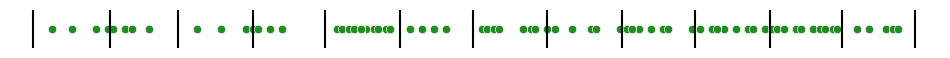

In [363]:
fig,ax=plt.subplots(figsize=(12,0.5))
sns.scatterplot(img_dates,x='DOY',y='x',ax=ax,color='forestgreen')
loc=[0,32,60,91,121,152,182,213,244,274,305,335,365]
for x in loc:
    plt.axvline(x=x,color='black')
ax.set_axis_off()
ax.set_ylim([0.8,1.2])
plt.savefig('../../../Working_Data/images density.png')

# Spatial RF

In [80]:
# Extract geometry information
train['lon'] = train['geometry'].x
train['lat'] = train['geometry'].y
test['lon'] = test['geometry'].x
test['lat'] = test['geometry'].y
validation['lon'] = validation['geometry'].x
validation['lat'] = validation['geometry'].y

C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [81]:
# Drop columns that aren't used in RF
train=train.drop(['PtID','geometry'],axis=1)
test=test.drop(['PtID','geometry'],axis=1)
validation=validation.drop(['PtID','geometry'],axis=1)

In [82]:
# Data preparation function from SPRF GitHub docs
def prepare_data(data, target, lon="lon", lat="lat"):
    """Assumes that all other columns are used as covariates"""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [83]:
# Pre-process data into format for RF models
train_x, train_y, train_coords = prepare_data(
    train,'invasive'
)
test_x, test_y, test_coords = prepare_data(
    test, 'invasive'
)
validation_x, validation_y, validation_coords = prepare_data(
    validation, 'invasive'
)

# Basic RF Model

In [84]:
# Train basic random forest model
rf = RandomForestClassifier()
rf.fit(train_x, train_y)
test_pred = rf.predict(test_x)

rmse_rf = root_mean_squared_error(test_pred, test_y)
print("Error of basic Random Forest: ", rmse_rf)

Error of basic Random Forest:  0.29814239699997197


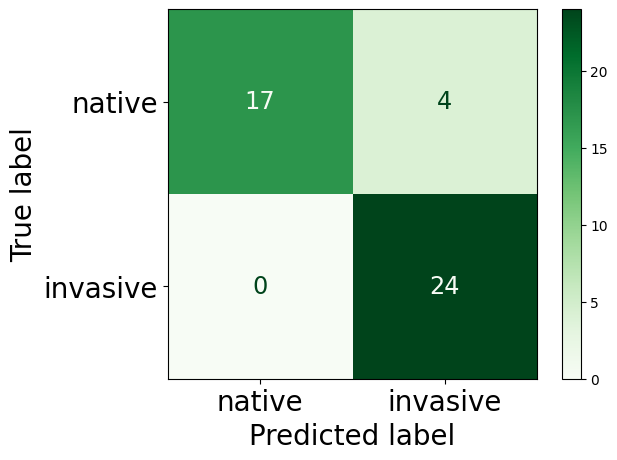

In [85]:
# Confusion Matrix 
ax=ConfusionMatrixDisplay.from_predictions(test_y,test_pred,labels=rf.classes_,cmap='Greens',text_kw={'size':'xx-large'},colorbar=True)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.xticks([0,1],['native','invasive'],fontsize=20)
plt.yticks([0,1],['native','invasive'],fontsize=20)
plt.savefig('../Working_Data/ConfusionMatrixBasicRF.png',dpi=300,bbox_inches='tight')

In [86]:
# Calculate Cohen's Kappa 
cohen_kappa_score(test_y,test_pred)

0.8192771084337349

In [87]:
# Predict with basic RF
basic_results=rf.predict(validation_x)

In [88]:
# Create geodataframe from predicted results
basic_out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':basic_results})
basic_out_gdf = gpd.GeoDataFrame(
    basic_out_df, geometry=gpd.points_from_xy(basic_out_df.lon, basic_out_df.lat), crs="EPSG:4326"
)

# Spatial RF

In [146]:
# Train spatial RF
sp = SpatialRandomForest(
    max_depth=10, neighbors=10
)
sp.fit(train_x, train_y, train_coords)
test_pred_spatial = sp.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("Error of spatial Random Forest: ", rmse_spatial_rf)

Error of spatial Random Forest:  0.29814239699997197


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [147]:
# Apply thresholding of >0.5 to invasive and below to native
for i in np.arange(0,test_pred_spatial.size):
    if test_pred_spatial[i] >0.5:
        test_pred_spatial[i]=1
    else:
        test_pred_spatial[i]=0

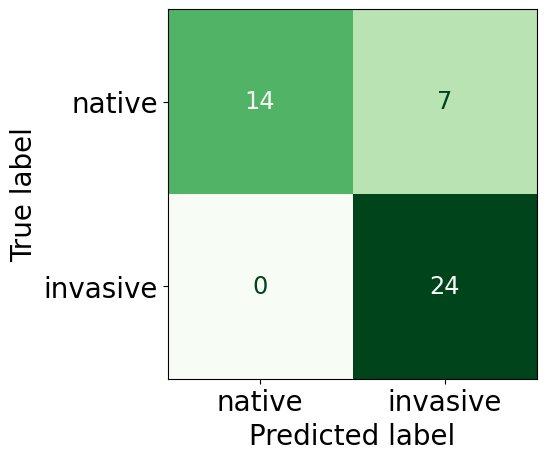

In [148]:
ax=ConfusionMatrixDisplay.from_predictions(test_y,test_pred_spatial,labels=rf.classes_,cmap='Greens',text_kw={'size':'xx-large'},colorbar=False)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.xticks([0,1],['native','invasive'],fontsize=20)
plt.yticks([0,1],['native','invasive'],fontsize=20)
plt.savefig('../Working_Data/ConfusionMatrixSpatialRF.png',dpi=300,bbox_inches='tight')

In [149]:
# Cohen's Kappa 
cohen_kappa_score(test_y,test_pred_spatial)

0.6808510638297872

In [145]:
# Predict with spatial RF
results=sp.predict(validation_x,validation_coords)
for i in np.arange(0,results.size):
    if results[i] >0.5:
        results[i]=1
    else:
        results[i]=0

In [101]:
# Create dataframe of results
out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':results})

In [102]:
# Convert to a geodataframe 
out_gdf = gpd.GeoDataFrame(
    out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Tuned Spatial RF

In [103]:
# Train tuned spatial RF
regr = SpatialRandomForest(
        n_estimators=91, neighbors=500, max_depth=10
    )
regr.tune_neighbors(train_x, train_y, train_coords)
print("spatial rf tuned:", regr.neighbors)
regr.fit(train_x, train_y, train_coords)
test_pred_regr = regr.predict(test_x, test_coords)
rmse_spatial_rf_tuned = mean_squared_error(test_pred_regr, test_y, squared=False)
print("Error of tuned spatial Random Forest: ", rmse_spatial_rf_tuned)

C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmea

spatial rf tuned: 83


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Error of tuned spatial Random Forest:  0.3444336946913842


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [104]:
# Convert to binary classes
for i in np.arange(0,test_pred_regr.size):
    if test_pred_regr[i] >0.5:
        test_pred_regr[i]=1
    else:
        test_pred_regr[i]=0

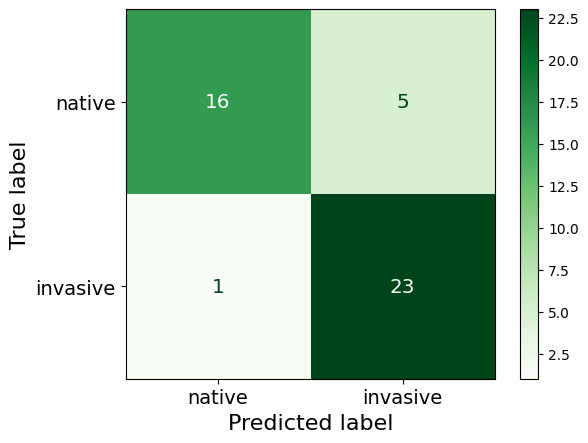

In [105]:
# Confusion matrix 
ax=ConfusionMatrixDisplay.from_predictions(test_y,test_pred_regr,labels=rf.classes_,cmap='Greens',text_kw={'size':'x-large'},colorbar=True)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label',fontsize=16)
plt.xticks([0,1],['native','invasive'],fontsize=14)
plt.yticks([0,1],['native','invasive'],fontsize=14)
plt.savefig('../Working_Data/ConfusionMatrixTunedRF.png')

In [106]:
# Cohen's kappa
cohen_kappa_score(test_y,test_pred_regr)

0.7289156626506024

In [107]:
# Predict with tuned spatial RF
results=regr.predict(validation_x,validation_coords)
for i in np.arange(0,results.size):
    if results[i] >0.5:
        results[i]=1
    else:
        results[i]=0

In [108]:
# Combine into dataframe
tuned_out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':results})

In [109]:
# Convert to geodataframe
tuned_out_gdf = gpd.GeoDataFrame(
    tuned_out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Geographic RF

In [110]:
# Train geographic RF
geo_rf = GeographicalRandomForest(
    n_estimators=100, neighbors=10, max_depth=10
)
geo_rf.fit(train_x, train_y, train_coords)
test_pred_geo = geo_rf.predict(test_x, test_coords)

rmse_geo_rf = mean_squared_error(test_pred_geo, test_y, squared=False)
print("Error of spatial Random Forest: ", rmse_geo_rf)

Error of spatial Random Forest:  0.23759442567348066


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [111]:
# Convert to binary outcome
for i in np.arange(0,test_pred_geo.size):
    if test_pred_geo[i] >0.5:
        test_pred_geo[i]=1
    else:
        test_pred_geo[i]=0

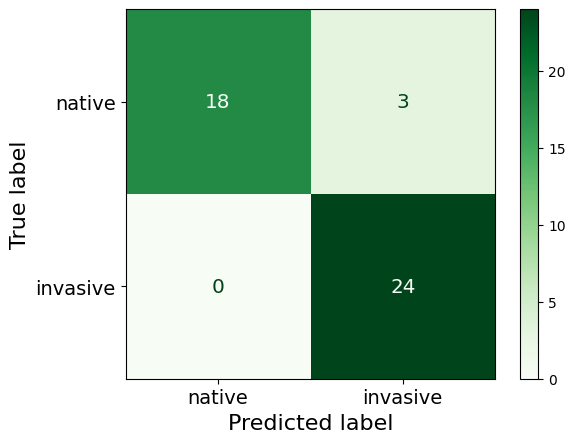

In [112]:
# Confusion matrix
ax=ConfusionMatrixDisplay.from_predictions(test_y,test_pred_geo,labels=rf.classes_,cmap='Greens',text_kw={'size':'x-large'},colorbar=True)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label',fontsize=16)
plt.xticks([0,1],['native','invasive'],fontsize=14)
plt.yticks([0,1],['native','invasive'],fontsize=14)
plt.savefig('../Working_Data/ConfusionMatrixGeoRF.png')

In [113]:
# Cohen's kappa 
cohen_kappa_score(test_y,test_pred_geo)

0.8648648648648649

In [114]:
# Predict with geographic RF

results=geo_rf.predict(validation_x,validation_coords)
for i in np.arange(0,results.size):
    if results[i] >0.5:
        results[i]=1
    else:
        results[i]=0

In [115]:
# Combine into dataframe
geo_out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':np.ravel(results)})

In [116]:
# Convert to geodataframe
geo_out_gdf = gpd.GeoDataFrame(
    geo_out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Predicted Area

In [117]:
# Find number of points in each
basic_out_gdf.groupby('result').count()

,lon,lat,geometry
result,,,
0.0,18929,18929,18929
1.0,33546,33546,33546


In [132]:
33546/(33546+18929)

0.6392758456407813

In [119]:
# Find number of points in each
out_gdf.groupby('result').count()

,lon,lat,geometry
result,,,
0.0,6922,6922,6922
1.0,45553,45553,45553


In [134]:
45553/(45553+6922)

0.8680895664602192

In [121]:
# Find number of points in each
tuned_out_gdf.groupby('result').count()

,lon,lat,geometry
result,,,
0.0,25275,25275,25275
1.0,27200,27200,27200


In [136]:
27200/(27200+25275)

0.5183420676512626

In [123]:
# Find number of points in each
geo_out_gdf.groupby('result').count()

,lon,lat,geometry
result,,,
0.0,33629,33629,33629
1.0,18846,18846,18846


In [135]:
18846/(18846+33629)

0.3591424487851358

# Plots

In [125]:
# Convert to geocubes
out_grid= make_geocube(vector_data=out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))
basic_out_grid=make_geocube(vector_data=basic_out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))
tuned_out_grid=make_geocube(vector_data=tuned_out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))
geo_out_grid=make_geocube(vector_data=geo_out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))

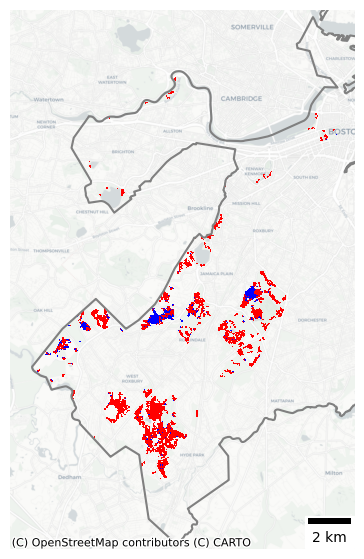

In [126]:
# Graph spatial RF results
fig, ax =plt.subplots(figsize=(6,7))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=out_grid['result'].plot(cmap='bwr',ax=ax)
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='blue', label='native')
red_patch = mpl.patches.Patch(color='red', label='invasive')
#ax.legend(handles=[blue_patch,red_patch])
ax.set_xlim([-7.926e6,-7.91e6])
ax.set_ylim([5.195e6,5.22e6])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('')
ax.axis('off')
plt.savefig('SpatialRFResults.png',dpi=300,bbox_inches='tight')

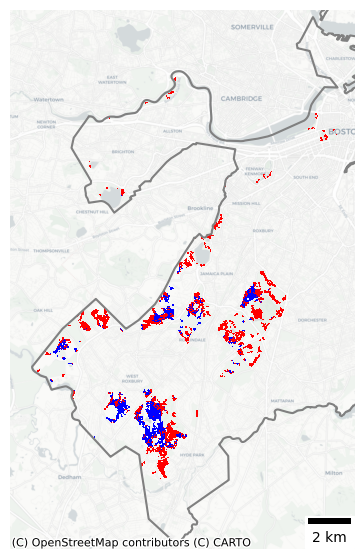

In [127]:
# Graph basic RF
fig, ax =plt.subplots(figsize=(6,7))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=basic_out_grid['result'].plot(cmap='bwr',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='blue', label='native')
red_patch = mpl.patches.Patch(color='red', label='invasive')
#ax.legend(handles=[blue_patch,red_patch])
ax.set_xlim([-7.926e6,-7.91e6])
ax.set_ylim([5.195e6,5.22e6])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('')
plt.savefig('BasicRFResults.png',dpi=300,bbox_inches='tight')

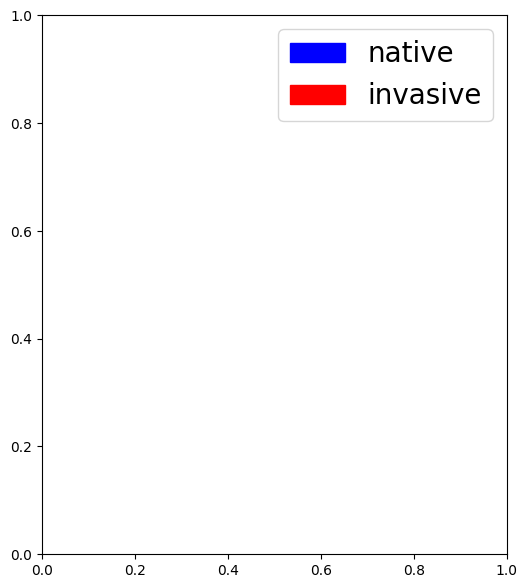

In [128]:
fig, ax =plt.subplots(figsize=(6,7))
blue_patch = mpl.patches.Patch(color='blue', label='native')
red_patch = mpl.patches.Patch(color='red', label='invasive')
ax.legend(handles=[blue_patch,red_patch],fontsize=20)
fig.savefig('Class legend.png',dpi=300,bbox_inches='tight')

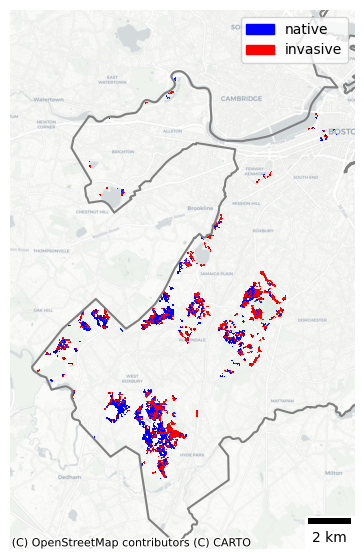

In [129]:
# Graph tuned spatial RF results
fig, ax =plt.subplots(figsize=(6,7))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=tuned_out_grid['result'].plot(cmap='bwr',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='blue', label='native')
red_patch = mpl.patches.Patch(color='red', label='invasive')
ax.legend(handles=[blue_patch,red_patch])
ax.set_xlim([-7.926e6,-7.91e6])
ax.set_ylim([5.195e6,5.22e6])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('')
plt.savefig('TunedRFResults.png',dpi=300,bbox_inches='tight')

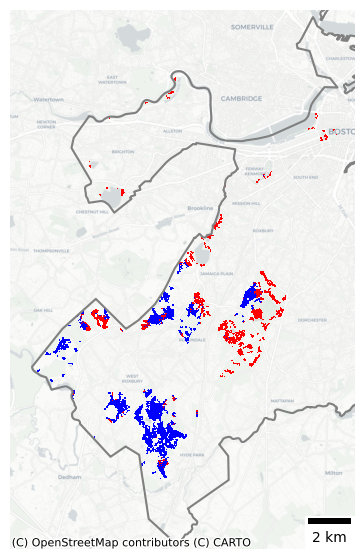

In [130]:
# Graph geographic RF results
fig, ax =plt.subplots(figsize=(6,7))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=geo_out_grid['result'].plot(cmap='bwr',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='blue', label='native')
red_patch = mpl.patches.Patch(color='red', label='invasive')
#ax.legend(handles=[blue_patch,red_patch])
ax.set_xlim([-7.926e6,-7.91e6])
ax.set_ylim([5.195e6,5.22e6])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('')
plt.savefig('GeoRFResults.png',dpi=300,bbox_inches='tight')

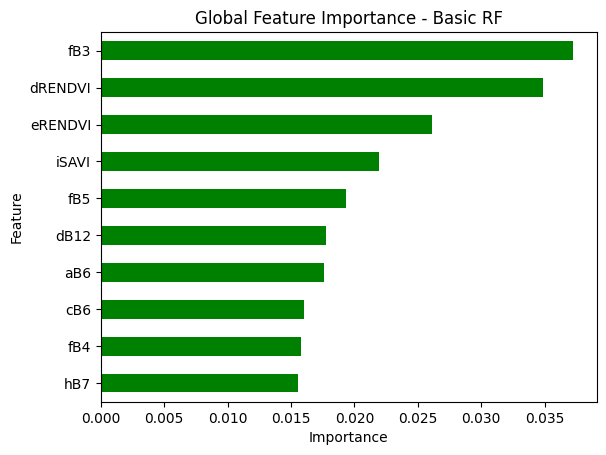

In [131]:
# Global importances from basic RF
global_importances = pd.Series(rf.feature_importances_, index=train_x.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances[-10:].plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Basic RF")
plt.savefig('Feature Importance.png',dpi=300,bbox_inches='tight')